In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!pip install mmcv-full -f https://download.openmmlab.com/mmcv/dist/cu111/torch1.10.0/index.html
!git clone https://github.com/open-mmlab/mmsegmentation.git

Looking in links: https://download.openmmlab.com/mmcv/dist/cu111/torch1.10.0/index.html
fatal: destination path 'mmsegmentation' already exists and is not an empty directory.


In [ ]:
import torch

print(f"Setup complete. Using torch {torch.__version__} ({torch.cuda.get_device_properties(0).name if torch.cuda.is_available() else 'CPU'})")

Setup complete. Using torch 1.11.0+cu113 (Tesla T4)


In [ ]:
%cd mmsegmentation

/content/mmsegmentation


In [ ]:
from mmseg.apis import inference_segmentor, init_segmentor, show_result_pyplot
import mmcv

In [ ]:
import os.path as osp
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

In [ ]:
!mkdir checkpoints
!wget -O //content/mmsegmentation/checkpoints/fpn_r101_512x1024_80k_cityscapes_20200717_012416-c5800d4c.pth https://download.openmmlab.com/mmsegmentation/v0.5/sem_fpn/fpn_r101_512x1024_80k_cityscapes/fpn_r101_512x1024_80k_cityscapes_20200717_012416-c5800d4c.pth

mkdir: cannot create directory ‘checkpoints’: File exists
--2022-05-09 15:14:51--  https://download.openmmlab.com/mmsegmentation/v0.5/sem_fpn/fpn_r101_512x1024_80k_cityscapes/fpn_r101_512x1024_80k_cityscapes_20200717_012416-c5800d4c.pth
Resolving download.openmmlab.com (download.openmmlab.com)... 47.252.96.28
Connecting to download.openmmlab.com (download.openmmlab.com)|47.252.96.28|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 190509585 (182M) [application/octet-stream]
Saving to: ‘//content/mmsegmentation/checkpoints/fpn_r101_512x1024_80k_cityscapes_20200717_012416-c5800d4c.pth’

//content/mmsegment 100%[===================>] 181.68M  7.80MB/s    in 22s     

2022-05-09 15:15:15 (8.25 MB/s) - ‘//content/mmsegmentation/checkpoints/fpn_r101_512x1024_80k_cityscapes_20200717_012416-c5800d4c.pth’ saved [190509585/190509585]



In [ ]:
from mmseg.datasets.builder import DATASETS
from mmseg.datasets.custom import CustomDataset

classes = ('background', 'building', 'road')
palette = [[0, 0, 0], [128, 128, 0], [128, 64, 128]]

@DATASETS.register_module()
class SIADataset(CustomDataset):
  CLASSES = classes
  PALETTE = palette
  def __init__(self, split, **kwargs):
    super().__init__(img_suffix='.png', seg_map_suffix='.png', 
                     split=split, **kwargs)
    assert osp.exists(self.img_dir) and self.split is not None

In [ ]:
# config 파일을 설정하고, 다운로드 받은 pretrained 모델을 checkpoint로 설정. 
config_file = '/content/mmsegmentation/configs/sem_fpn/fpn_r101_512x1024_80k_cityscapes.py'
checkpoint_file = '/content/mmsegmentation/checkpoints/fpn_r101_512x1024_80k_cityscapes_20200717_012416-c5800d4c.pth'

from mmcv import Config

cfg = Config.fromfile(config_file)
print(cfg.pretty_text)

norm_cfg = dict(type='SyncBN', requires_grad=True)
model = dict(
    type='EncoderDecoder',
    pretrained='open-mmlab://resnet101_v1c',
    backbone=dict(
        type='ResNetV1c',
        depth=101,
        num_stages=4,
        out_indices=(0, 1, 2, 3),
        dilations=(1, 1, 1, 1),
        strides=(1, 2, 2, 2),
        norm_cfg=dict(type='SyncBN', requires_grad=True),
        norm_eval=False,
        style='pytorch',
        contract_dilation=True),
    neck=dict(
        type='FPN',
        in_channels=[256, 512, 1024, 2048],
        out_channels=256,
        num_outs=4),
    decode_head=dict(
        type='FPNHead',
        in_channels=[256, 256, 256, 256],
        in_index=[0, 1, 2, 3],
        feature_strides=[4, 8, 16, 32],
        channels=128,
        dropout_ratio=0.1,
        num_classes=19,
        norm_cfg=dict(type='SyncBN', requires_grad=True),
        align_corners=False,
        loss_decode=dict(
            type='CrossEntropyLoss', use_sigmoid=False, loss_weight=1

In [ ]:
norm_cfg = dict(type='BN', requires_grad=True)
model = dict(
    type='EncoderDecoder',
    pretrained='open-mmlab://resnet101_v1c',
    backbone=dict(
        type='ResNetV1c',
        depth=101,
        num_stages=4,
        out_indices=(0, 1, 2, 3),
        dilations=(1, 1, 1, 1),
        strides=(1, 2, 2, 2),
        norm_cfg=dict(type='BN', requires_grad=True),
        norm_eval=False,
        style='pytorch',
        contract_dilation=True),
    neck=dict(
        type='FPN',
        in_channels=[256, 512, 1024, 2048],
        out_channels=256,
        num_outs=4),
    decode_head=dict(
        type='FPNHead',
        in_channels=[256, 256, 256, 256],
        in_index=[0, 1, 2, 3],
        feature_strides=[4, 8, 16, 32],
        channels=128,
        dropout_ratio=0.1,
        num_classes=19,
        norm_cfg=dict(type='BN', requires_grad=True),
        align_corners=False,
        loss_decode=dict(
            type='CrossEntropyLoss', use_sigmoid=False, loss_weight=1.0)),
    train_cfg=dict(),
    test_cfg=dict(mode='whole'))
dataset_type = 'CityscapesDataset'
data_root = 'data/cityscapes/'
img_norm_cfg = dict(
    mean=[123.675, 116.28, 103.53], std=[58.395, 57.12, 57.375], to_rgb=True)
crop_size = (512, 1024)
train_pipeline = [
    dict(type='LoadImageFromFile'),
    dict(type='LoadAnnotations'),
    dict(type='Resize', img_scale=(2048, 1024), ratio_range=(0.5, 2.0)),
    dict(type='RandomCrop', crop_size=(512, 1024), cat_max_ratio=0.75),
    dict(type='RandomFlip', prob=0.5),
    dict(type='PhotoMetricDistortion'),
    dict(
        type='Normalize',
        mean=[123.675, 116.28, 103.53],
        std=[58.395, 57.12, 57.375],
        to_rgb=True),
    dict(type='Pad', size=(512, 1024), pad_val=0, seg_pad_val=255),
    dict(type='DefaultFormatBundle'),
    dict(type='Collect', keys=['img', 'gt_semantic_seg'])
]
test_pipeline = [
    dict(type='LoadImageFromFile'),
    dict(
        type='MultiScaleFlipAug',
        img_scale=(2048, 1024),
        flip=False,
        transforms=[
            dict(type='Resize', keep_ratio=True),
            dict(type='RandomFlip'),
            dict(
                type='Normalize',
                mean=[123.675, 116.28, 103.53],
                std=[58.395, 57.12, 57.375],
                to_rgb=True),
            dict(type='ImageToTensor', keys=['img']),
            dict(type='Collect', keys=['img'])
        ])
]
data = dict(
    samples_per_gpu=2,
    workers_per_gpu=2,
    train=dict(
        type='CityscapesDataset',
        data_root='data/cityscapes/',
        img_dir='leftImg8bit/train',
        ann_dir='gtFine/train',
        pipeline=[
            dict(type='LoadImageFromFile'),
            dict(type='LoadAnnotations'),
            dict(
                type='Resize', img_scale=(2048, 1024), ratio_range=(0.5, 2.0)),
            dict(type='RandomCrop', crop_size=(512, 1024), cat_max_ratio=0.75),
            dict(type='RandomFlip', prob=0.5),
            dict(type='PhotoMetricDistortion'),
            dict(
                type='Normalize',
                mean=[123.675, 116.28, 103.53],
                std=[58.395, 57.12, 57.375],
                to_rgb=True),
            dict(type='Pad', size=(512, 1024), pad_val=0, seg_pad_val=255),
            dict(type='DefaultFormatBundle'),
            dict(type='Collect', keys=['img', 'gt_semantic_seg'])
        ]),
    val=dict(
        type='CityscapesDataset',
        data_root='data/cityscapes/',
        img_dir='leftImg8bit/val',
        ann_dir='gtFine/val',
        pipeline=[
            dict(type='LoadImageFromFile'),
            dict(
                type='MultiScaleFlipAug',
                img_scale=(2048, 1024),
                flip=False,
                transforms=[
                    dict(type='Resize', keep_ratio=True),
                    dict(type='RandomFlip'),
                    dict(
                        type='Normalize',
                        mean=[123.675, 116.28, 103.53],
                        std=[58.395, 57.12, 57.375],
                        to_rgb=True),
                    dict(type='ImageToTensor', keys=['img']),
                    dict(type='Collect', keys=['img'])
                ])
        ]),
    test=dict(
        type='CityscapesDataset',
        data_root='data/cityscapes/',
        img_dir='leftImg8bit/val',
        ann_dir='gtFine/val',
        pipeline=[
            dict(type='LoadImageFromFile'),
            dict(
                type='MultiScaleFlipAug',
                img_scale=(2048, 1024),
                flip=False,
                transforms=[
                    dict(type='Resize', keep_ratio=True),
                    dict(type='RandomFlip'),
                    dict(
                        type='Normalize',
                        mean=[123.675, 116.28, 103.53],
                        std=[58.395, 57.12, 57.375],
                        to_rgb=True),
                    dict(type='ImageToTensor', keys=['img']),
                    dict(type='Collect', keys=['img'])
                ])
        ]))
log_config = dict(
    interval=50, hooks=[dict(type='TextLoggerHook', by_epoch=False)])
dist_params = dict(backend='nccl')
log_level = 'INFO'
load_from = None
resume_from = None
workflow = [('train', 1)]
cudnn_benchmark = True
optimizer = dict(type='SGD', lr=0.01, momentum=0.9, weight_decay=0.0005)
optimizer_config = dict()
lr_config = dict(policy='poly', power=0.9, min_lr=0.0001, by_epoch=False)
runner = dict(type='IterBasedRunner', max_iters=80000)
checkpoint_config = dict(by_epoch=False, interval=8000)
evaluation = dict(interval=8000, metric='mIoU', pre_eval=True)

In [ ]:
model = dict(
    type='EncoderDecoder',
    pretrained='open-mmlab://resnet101_v1c',
    backbone=dict(
        type='ResNetV1c',
        depth=101,
        num_stages=4,
        out_indices=(0, 1, 2, 3),
        dilations=(1, 1, 1, 1),
        strides=(1, 2, 2, 2),
        norm_cfg=dict(type='BN', requires_grad=True),
        norm_eval=False,
        style='pytorch',
        contract_dilation=True),
    neck=dict(
        type='FPN',
        in_channels=[256, 512, 1024, 2048],
        out_channels=256,
        num_outs=4),
    decode_head=dict(
        type='FPNHead',
        in_channels=[256, 256, 256, 256],
        in_index=[0, 1, 2, 3],
        feature_strides=[4, 8, 16, 32],
        channels=128,
        dropout_ratio=0.1,
        num_classes=19,
        norm_cfg=dict(type='BN', requires_grad=True),
        align_corners=False,
        loss_decode=dict(
            type='CrossEntropyLoss', use_sigmoid=False, loss_weight=1.0)),
    train_cfg=dict(),
    test_cfg=dict(mode='whole'))

In [ ]:
img_norm_cfg = dict(
    mean=[123.675, 116.28, 103.53], std=[58.395, 57.12, 57.375], to_rgb=True)
crop_size = (512, 1024)
train_pipeline = [
    dict(type='LoadImageFromFile'),
    dict(type='LoadAnnotations'),
    dict(type='Resize', img_scale=(2048, 1024), ratio_range=(0.5, 2.0)),
    dict(type='RandomCrop', crop_size=(512, 1024), cat_max_ratio=0.75),
    dict(type='RandomFlip', prob=0.5),
    dict(type='PhotoMetricDistortion'),
    dict(
        type='Normalize',
        mean=[123.675, 116.28, 103.53],
        std=[58.395, 57.12, 57.375],
        to_rgb=True),
    dict(type='Pad', size=(512, 1024), pad_val=0, seg_pad_val=255),
    dict(type='DefaultFormatBundle'),
    dict(type='Collect', keys=['img', 'gt_semantic_seg'])
]
test_pipeline = [
    dict(type='LoadImageFromFile'),
    dict(
        type='MultiScaleFlipAug',
        img_scale=(2048, 1024),
        flip=False,
        transforms=[
            dict(type='Resize', keep_ratio=True),
            dict(type='RandomFlip'),
            dict(
                type='Normalize',
                mean=[123.675, 116.28, 103.53],
                std=[58.395, 57.12, 57.375],
                to_rgb=True),
            dict(type='ImageToTensor', keys=['img']),
            dict(type='Collect', keys=['img'])
        ])
]

In [ ]:
dataset_type = 'CityscapesDataset'
data_root = 'data/cityscapes/'

data = dict(
    samples_per_gpu=2,  #batch size
    workers_per_gpu=2,  
    train=dict(
        type='CityscapesDataset',
        data_root='data/cityscapes/',
        img_dir='leftImg8bit/train',
        ann_dir='gtFine/train',
        pipeline=[
            dict(type='LoadImageFromFile'),
            dict(type='LoadAnnotations'),
            dict(
                type='Resize', img_scale=(2048, 1024), ratio_range=(0.5, 2.0)),
            dict(type='RandomCrop', crop_size=(512, 1024), cat_max_ratio=0.75),
            dict(type='RandomFlip', prob=0.5),
            dict(type='PhotoMetricDistortion'),
            dict(
                type='Normalize',
                mean=[123.675, 116.28, 103.53],
                std=[58.395, 57.12, 57.375],
                to_rgb=True),
            dict(type='Pad', size=(512, 1024), pad_val=0, seg_pad_val=255),
            dict(type='DefaultFormatBundle'),
            dict(type='Collect', keys=['img', 'gt_semantic_seg'])
        ]),
    val=dict(
        type='CityscapesDataset',
        data_root='data/cityscapes/',
        img_dir='leftImg8bit/val',
        ann_dir='gtFine/val',
        pipeline=[
            dict(type='LoadImageFromFile'),
            dict(
                type='MultiScaleFlipAug',
                img_scale=(2048, 1024),
                flip=False,
                transforms=[
                    dict(type='Resize', keep_ratio=True),
                    dict(type='RandomFlip'),
                    dict(
                        type='Normalize',
                        mean=[123.675, 116.28, 103.53],
                        std=[58.395, 57.12, 57.375],
                        to_rgb=True),
                    dict(type='ImageToTensor', keys=['img']),
                    dict(type='Collect', keys=['img'])
                ])
        ]),
    test=dict(
        type='CityscapesDataset',
        data_root='data/cityscapes/',
        img_dir='leftImg8bit/val',
        ann_dir='gtFine/val',
        pipeline=[
            dict(type='LoadImageFromFile'),
            dict(
                type='MultiScaleFlipAug',
                img_scale=(2048, 1024),
                flip=False,
                transforms=[
                    dict(type='Resize', keep_ratio=True),
                    dict(type='RandomFlip'),
                    dict(
                        type='Normalize',
                        mean=[123.675, 116.28, 103.53],
                        std=[58.395, 57.12, 57.375],
                        to_rgb=True),
                    dict(type='ImageToTensor', keys=['img']),
                    dict(type='Collect', keys=['img'])
                ])
        ]))

In [ ]:
cfg.norm_cfg = dict(type='BN', requires_grad=True)
cfg.model.backbone.norm_cfg = cfg.norm_cfg
cfg.model.decode_head.norm_cfg = cfg.norm_cfg

cfg.model.decode_head.num_classes = 3

In [ ]:
cfg.img_norm_cfg = dict(
    mean=[123.675, 116.28, 103.53], std=[58.395, 57.12, 57.375], to_rgb=True)
cfg.crop_size = (512, 1024)
cfg.train_pipeline = [
    dict(type='LoadImageFromFile'),
    dict(type='LoadAnnotations'),
    dict(type='Resize', img_scale=(1024, 1024), ratio_range=(0.5, 2.0)),
    dict(type='RandomCrop', crop_size=cfg.crop_size, cat_max_ratio=0.75),
    dict(type='RandomFlip', flip_ratio=0.5),
    dict(type='PhotoMetricDistortion'),
    dict(type='Normalize', **cfg.img_norm_cfg),
    dict(type='Pad', size=cfg.crop_size, pad_val=0, seg_pad_val=255),
    dict(type='DefaultFormatBundle'),
    dict(type='Collect', keys=['img', 'gt_semantic_seg']),
]

cfg.test_pipeline = [
    dict(type='LoadImageFromFile'),
    dict(
        type='MultiScaleFlipAug',
        img_scale=(1024, 1024),
        # img_ratios=[0.5, 0.75, 1.0, 1.25, 1.5, 1.75],
        flip=False,
        transforms=[
            dict(type='Resize', keep_ratio=True),
            dict(type='RandomFlip'),
            dict(type='Normalize', **cfg.img_norm_cfg),
            dict(type='ImageToTensor', keys=['img']),
            dict(type='Collect', keys=['img']),
        ])
]

In [ ]:
cfg.dataset_type = 'SIADataset'
cfg.data_root = '/content/drive/MyDrive/SIA'

cfg.data.train.type = 'SIADataset'
cfg.data.train.data_root = '/content/drive/MyDrive/SIA'
cfg.data.train.img_dir = 'images/up025'
cfg.data.train.ann_dir = 'labels'
cfg.data.train.pipeline = cfg.train_pipeline
cfg.data.train.split = '/content/drive/MyDrive/SIA/splits/building/train_building.txt'
cfg.data.val.type = 'SIADataset'
cfg.data.val.data_root = '/content/drive/MyDrive/SIA'
cfg.data.val.img_dir = 'images/up025'
cfg.data.val.ann_dir = 'labels'
cfg.data.val.pipeline = cfg.test_pipeline
cfg.data.val.split = '/content/drive/MyDrive/SIA/splits/building/val_building.txt'

cfg.data.test.type = 'SIADataset'
cfg.data.test.data_root = '/content/drive/MyDrive/SIA'
cfg.data.test.img_dir = 'images/up025'
cfg.data.test.ann_dir = 'labels'
cfg.data.test.pipeline = cfg.test_pipeline
cfg.data.test.split = '/content/drive/MyDrive/SIA/splits/building/val_building.txt'

In [ ]:
cfg.data.train.type = 'SIADataset'
cfg.data.train.data_root = '/content/drive/MyDrive/SIA'
cfg.data.train.img_dir = 'images/up025'
cfg.data.train.ann_dir = 'labels'
cfg.data.train.pipeline = cfg.train_pipeline
cfg.data.train.split = '/content/drive/MyDrive/SIA/splits/building/train_building.txt'

In [ ]:
cfg.load_from = '/content/mmsegmentation/checkpoints/fpn_r101_512x1024_80k_cityscapes_20200717_012416-c5800d4c.pth'

# Set up working dir to save files and logs.
cfg.work_dir = '/content/drive/MyDrive/SIA/semantic_checkpoint/fpn_building/bs'

In [ ]:
cfg.runner.max_iteTrs = 200
cfg.log_config.interval = 50
cfg.evaluation.interval = 1000  # 모델 학습시 평가를 몇 번째 iteration마다 할 것인지 지정
cfg.checkpoint_config.interval = 1000  # 모델 학습시 학습한 모델을 몇 번째 iteration마다 저장할 것인지 지정

cfg.runner = dict(type='IterBasedRunner', max_iters=20000)  # Iteration으로 동작, Epoch로 동작하게 변경할 수도 있음
# cfg.runner = dict(type='EpochBasedRunner', max_epochs=4000)  # Epoch로 변경
cfg.workflow = [('train', 1)]

# Set seed to facitate reproducing the result
cfg.seed = 0
#set_random_seed(0, deterministic=False)
cfg.gpu_ids = range(1)

# Let's have a look at the final config used for training
print(f'Config:\n{cfg.pretty_text}')

Config:
norm_cfg = dict(type='BN', requires_grad=True)
model = dict(
    type='EncoderDecoder',
    pretrained='open-mmlab://resnet101_v1c',
    backbone=dict(
        type='ResNetV1c',
        depth=101,
        num_stages=4,
        out_indices=(0, 1, 2, 3),
        dilations=(1, 1, 1, 1),
        strides=(1, 2, 2, 2),
        norm_cfg=dict(type='BN', requires_grad=True),
        norm_eval=False,
        style='pytorch',
        contract_dilation=True),
    neck=dict(
        type='FPN',
        in_channels=[256, 512, 1024, 2048],
        out_channels=256,
        num_outs=4),
    decode_head=dict(
        type='FPNHead',
        in_channels=[256, 256, 256, 256],
        in_index=[0, 1, 2, 3],
        feature_strides=[4, 8, 16, 32],
        channels=128,
        dropout_ratio=0.1,
        num_classes=3,
        norm_cfg=dict(type='BN', requires_grad=True),
        align_corners=False,
        loss_decode=dict(
            type='CrossEntropyLoss', use_sigmoid=False, loss_weight=1.0)),

In [ ]:
from mmseg.datasets import build_dataset
from mmseg.models import build_segmentor
from mmseg.apis import train_segmentor

# Build the dataset
datasets = [build_dataset(cfg.data.train)]

# Build the detector
model = build_segmentor(
    cfg.model, train_cfg=cfg.get('train_cfg'), test_cfg=cfg.get('test_cfg'))

# Add an attribute for visualization convenience
model.CLASSES = datasets[0].CLASSES

# Create work_dir
mmcv.mkdir_or_exist(osp.abspath(cfg.work_dir))
train_segmentor(model, datasets, cfg, distributed=False, validate=True,
                meta=dict(CLASSES=classes, PALETTE=palette))

2022-05-09 15:15:16,364 - mmseg - INFO - Loaded 600 images
/content/mmsegmentation/mmseg/models/backbones/resnet.py:431: UserWarning: DeprecationWarning: pretrained is a deprecated, please use "init_cfg" instead
  warnings.warn('DeprecationWarning: pretrained is a deprecated, '
/content/mmsegmentation/mmseg/models/losses/cross_entropy_loss.py:236: UserWarning: Default ``avg_non_ignore`` is False, if you would like to ignore the certain label and average loss over non-ignore labels, which is the same with PyTorch official cross_entropy, set ``avg_non_ignore=True``.
  'Default ``avg_non_ignore`` is False, if you would like to '
2022-05-09 15:15:20,869 - mmseg - INFO - Loaded 147 images
2022-05-09 15:15:20,874 - mmseg - INFO - load checkpoint from local path: /content/mmsegmentation/checkpoints/fpn_r101_512x1024_80k_cityscapes_20200717_012416-c5800d4c.pth
2022-05-09 15:15:21,061 - mmseg - WARNING - The model and loaded state dict do not match exactly

size mismatch for decode_head.conv_se

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 147/147, 2.2 task/s, elapsed: 66s, ETA:     0s

2022-05-09 15:25:38,752 - mmseg - INFO - per class results:
2022-05-09 15:25:38,754 - mmseg - INFO - 
+------------+-------+-------+
|   Class    |  IoU  |  Acc  |
+------------+-------+-------+
| background | 84.21 | 96.27 |
|  building  | 44.14 | 49.91 |
|    road    |  nan  |  nan  |
+------------+-------+-------+
2022-05-09 15:25:38,755 - mmseg - INFO - Summary:
2022-05-09 15:25:38,758 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 85.97 | 64.18 | 73.09 |
+-------+-------+-------+
2022-05-09 15:25:38,760 - mmseg - INFO - Iter(val) [147]	aAcc: 0.8597, mIoU: 0.6418, mAcc: 0.7309, IoU.background: 0.8421, IoU.building: 0.4414, IoU.road: nan, Acc.background: 0.9627, Acc.building: 0.4991, Acc.road: nan
2022-05-09 15:26:04,211 - mmseg - INFO - Iter [1050/20000]	lr: 9.531e-03, eta: 3:13:25, time: 1.830, data_time: 1.325, memory: 3725, decode.loss_ce: 0.3446, decode.acc_seg: 82.4571, loss: 0.3446
2022-05-09 15:26:29,884 - mmseg - INFO - Ite

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 147/147, 5.1 task/s, elapsed: 29s, ETA:     0s

2022-05-09 15:34:52,324 - mmseg - INFO - per class results:
2022-05-09 15:34:52,325 - mmseg - INFO - 
+------------+-------+-------+
|   Class    |  IoU  |  Acc  |
+------------+-------+-------+
| background | 84.23 | 98.34 |
|  building  | 39.13 | 41.41 |
|    road    |  nan  |  nan  |
+------------+-------+-------+
2022-05-09 15:34:52,327 - mmseg - INFO - Summary:
2022-05-09 15:34:52,328 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 85.69 | 61.68 | 69.87 |
+-------+-------+-------+
2022-05-09 15:34:52,330 - mmseg - INFO - Iter(val) [147]	aAcc: 0.8569, mIoU: 0.6168, mAcc: 0.6987, IoU.background: 0.8423, IoU.building: 0.3913, IoU.road: nan, Acc.background: 0.9834, Acc.building: 0.4141, Acc.road: nan
2022-05-09 15:35:18,191 - mmseg - INFO - Iter [2050/20000]	lr: 9.082e-03, eta: 2:54:41, time: 1.092, data_time: 0.579, memory: 3725, decode.loss_ce: 0.2519, decode.acc_seg: 88.1652, loss: 0.2519
2022-05-09 15:35:43,919 - mmseg - INFO - Ite

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 147/147, 5.1 task/s, elapsed: 29s, ETA:     0s

2022-05-09 15:44:05,070 - mmseg - INFO - per class results:
2022-05-09 15:44:05,072 - mmseg - INFO - 
+------------+-------+-------+
|   Class    |  IoU  |  Acc  |
+------------+-------+-------+
| background | 88.32 |  96.3 |
|  building  | 60.55 | 68.39 |
|    road    |  nan  |  nan  |
+------------+-------+-------+
2022-05-09 15:44:05,073 - mmseg - INFO - Summary:
2022-05-09 15:44:05,075 - mmseg - INFO - 
+------+-------+-------+
| aAcc |  mIoU |  mAcc |
+------+-------+-------+
| 90.1 | 74.44 | 82.35 |
+------+-------+-------+
2022-05-09 15:44:05,078 - mmseg - INFO - Iter(val) [147]	aAcc: 0.9010, mIoU: 0.7444, mAcc: 0.8235, IoU.background: 0.8832, IoU.building: 0.6055, IoU.road: nan, Acc.background: 0.9630, Acc.building: 0.6839, Acc.road: nan
2022-05-09 15:44:33,243 - mmseg - INFO - Iter [3050/20000]	lr: 8.631e-03, eta: 2:42:16, time: 1.138, data_time: 0.624, memory: 3725, decode.loss_ce: 0.2413, decode.acc_seg: 88.4384, loss: 0.2413
2022-05-09 15:44:59,063 - mmseg - INFO - Iter [31

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 147/147, 5.1 task/s, elapsed: 29s, ETA:     0s

2022-05-09 15:53:21,081 - mmseg - INFO - per class results:
2022-05-09 15:53:21,082 - mmseg - INFO - 
+------------+-------+-------+
|   Class    |  IoU  |  Acc  |
+------------+-------+-------+
| background | 88.68 | 94.79 |
|  building  | 64.19 | 75.91 |
|    road    |  nan  |  nan  |
+------------+-------+-------+
2022-05-09 15:53:21,083 - mmseg - INFO - Summary:
2022-05-09 15:53:21,086 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 90.59 | 76.44 | 85.35 |
+-------+-------+-------+
2022-05-09 15:53:21,089 - mmseg - INFO - Iter(val) [147]	aAcc: 0.9059, mIoU: 0.7644, mAcc: 0.8535, IoU.background: 0.8868, IoU.building: 0.6419, IoU.road: nan, Acc.background: 0.9479, Acc.building: 0.7591, Acc.road: nan
2022-05-09 15:53:46,936 - mmseg - INFO - Iter [4050/20000]	lr: 8.176e-03, eta: 2:31:20, time: 1.093, data_time: 0.581, memory: 3725, decode.loss_ce: 0.2209, decode.acc_seg: 89.6224, loss: 0.2209
2022-05-09 15:54:12,783 - mmseg - INFO - Ite

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 147/147, 5.1 task/s, elapsed: 29s, ETA:     0s

2022-05-09 16:02:34,312 - mmseg - INFO - per class results:
2022-05-09 16:02:34,313 - mmseg - INFO - 
+------------+-------+-------+
|   Class    |  IoU  |  Acc  |
+------------+-------+-------+
| background | 86.47 | 93.87 |
|  building  | 57.69 | 70.06 |
|    road    |  nan  |  nan  |
+------------+-------+-------+
2022-05-09 16:02:34,314 - mmseg - INFO - Summary:
2022-05-09 16:02:34,318 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 88.58 | 72.08 | 81.97 |
+-------+-------+-------+
2022-05-09 16:02:34,319 - mmseg - INFO - Iter(val) [147]	aAcc: 0.8858, mIoU: 0.7208, mAcc: 0.8197, IoU.background: 0.8647, IoU.building: 0.5769, IoU.road: nan, Acc.background: 0.9387, Acc.building: 0.7006, Acc.road: nan
2022-05-09 16:03:00,230 - mmseg - INFO - Iter [5050/20000]	lr: 7.719e-03, eta: 2:21:03, time: 1.092, data_time: 0.578, memory: 3725, decode.loss_ce: 0.2475, decode.acc_seg: 88.5658, loss: 0.2475
2022-05-09 16:03:26,046 - mmseg - INFO - Ite

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 147/147, 5.1 task/s, elapsed: 29s, ETA:     0s

2022-05-09 16:11:48,145 - mmseg - INFO - per class results:
2022-05-09 16:11:48,146 - mmseg - INFO - 
+------------+-------+-------+
|   Class    |  IoU  |  Acc  |
+------------+-------+-------+
| background |  89.3 | 94.65 |
|  building  | 66.58 | 79.05 |
|    road    |  nan  |  nan  |
+------------+-------+-------+
2022-05-09 16:11:48,147 - mmseg - INFO - Summary:
2022-05-09 16:11:48,149 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 91.18 | 77.94 | 86.85 |
+-------+-------+-------+
2022-05-09 16:11:48,150 - mmseg - INFO - Iter(val) [147]	aAcc: 0.9118, mIoU: 0.7794, mAcc: 0.8685, IoU.background: 0.8930, IoU.building: 0.6658, IoU.road: nan, Acc.background: 0.9465, Acc.building: 0.7905, Acc.road: nan
2022-05-09 16:12:16,318 - mmseg - INFO - Iter [6050/20000]	lr: 7.259e-03, eta: 2:11:14, time: 1.139, data_time: 0.624, memory: 3725, decode.loss_ce: 0.2369, decode.acc_seg: 88.8378, loss: 0.2369
2022-05-09 16:12:42,157 - mmseg - INFO - Ite

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 147/147, 5.1 task/s, elapsed: 29s, ETA:     0s

2022-05-09 16:21:04,252 - mmseg - INFO - per class results:
2022-05-09 16:21:04,253 - mmseg - INFO - 
+------------+-------+-------+
|   Class    |  IoU  |  Acc  |
+------------+-------+-------+
| background | 87.58 | 98.07 |
|  building  | 54.41 | 58.08 |
|    road    |  nan  |  nan  |
+------------+-------+-------+
2022-05-09 16:21:04,254 - mmseg - INFO - Summary:
2022-05-09 16:21:04,256 - mmseg - INFO - 
+-------+------+-------+
|  aAcc | mIoU |  mAcc |
+-------+------+-------+
| 89.18 | 71.0 | 78.08 |
+-------+------+-------+
2022-05-09 16:21:04,258 - mmseg - INFO - Iter(val) [147]	aAcc: 0.8918, mIoU: 0.7100, mAcc: 0.7808, IoU.background: 0.8758, IoU.building: 0.5441, IoU.road: nan, Acc.background: 0.9807, Acc.building: 0.5808, Acc.road: nan
2022-05-09 16:21:30,173 - mmseg - INFO - Iter [7050/20000]	lr: 6.795e-03, eta: 2:01:30, time: 1.094, data_time: 0.581, memory: 3725, decode.loss_ce: 0.1940, decode.acc_seg: 91.1401, loss: 0.1940
2022-05-09 16:21:56,008 - mmseg - INFO - Iter [71

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 147/147, 5.1 task/s, elapsed: 29s, ETA:     0s

2022-05-09 16:30:17,753 - mmseg - INFO - per class results:
2022-05-09 16:30:17,754 - mmseg - INFO - 
+------------+-------+-------+
|   Class    |  IoU  |  Acc  |
+------------+-------+-------+
| background | 89.54 |  95.8 |
|  building  | 65.87 | 75.56 |
|    road    |  nan  |  nan  |
+------------+-------+-------+
2022-05-09 16:30:17,755 - mmseg - INFO - Summary:
2022-05-09 16:30:17,758 - mmseg - INFO - 
+------+-------+-------+
| aAcc |  mIoU |  mAcc |
+------+-------+-------+
| 91.3 | 77.71 | 85.68 |
+------+-------+-------+
2022-05-09 16:30:17,760 - mmseg - INFO - Iter(val) [147]	aAcc: 0.9130, mIoU: 0.7771, mAcc: 0.8568, IoU.background: 0.8954, IoU.building: 0.6587, IoU.road: nan, Acc.background: 0.9580, Acc.building: 0.7556, Acc.road: nan
2022-05-09 16:30:43,642 - mmseg - INFO - Iter [8050/20000]	lr: 6.328e-03, eta: 1:51:53, time: 1.092, data_time: 0.579, memory: 3725, decode.loss_ce: 0.2106, decode.acc_seg: 90.4145, loss: 0.2106
2022-05-09 16:31:09,500 - mmseg - INFO - Iter [81

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 147/147, 5.1 task/s, elapsed: 29s, ETA:     0s

2022-05-09 16:39:31,329 - mmseg - INFO - per class results:
2022-05-09 16:39:31,331 - mmseg - INFO - 
+------------+-------+-------+
|   Class    |  IoU  |  Acc  |
+------------+-------+-------+
| background | 87.68 |  97.5 |
|  building  |  55.9 | 60.79 |
|    road    |  nan  |  nan  |
+------------+-------+-------+
2022-05-09 16:39:31,332 - mmseg - INFO - Summary:
2022-05-09 16:39:31,335 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 89.34 | 71.79 | 79.15 |
+-------+-------+-------+
2022-05-09 16:39:31,338 - mmseg - INFO - Iter(val) [147]	aAcc: 0.8934, mIoU: 0.7179, mAcc: 0.7915, IoU.background: 0.8768, IoU.building: 0.5590, IoU.road: nan, Acc.background: 0.9750, Acc.building: 0.6079, Acc.road: nan
2022-05-09 16:39:59,534 - mmseg - INFO - Iter [9050/20000]	lr: 5.857e-03, eta: 1:42:24, time: 1.140, data_time: 0.626, memory: 3725, decode.loss_ce: 0.2066, decode.acc_seg: 90.4599, loss: 0.2066
2022-05-09 16:40:25,413 - mmseg - INFO - Ite

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 147/147, 5.1 task/s, elapsed: 29s, ETA:     0s

2022-05-09 16:48:46,881 - mmseg - INFO - per class results:
2022-05-09 16:48:46,882 - mmseg - INFO - 
+------------+-------+-------+
|   Class    |  IoU  |  Acc  |
+------------+-------+-------+
| background | 89.71 | 94.22 |
|  building  | 68.54 | 82.42 |
|    road    |  nan  |  nan  |
+------------+-------+-------+
2022-05-09 16:48:46,884 - mmseg - INFO - Summary:
2022-05-09 16:48:46,885 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 91.59 | 79.13 | 88.32 |
+-------+-------+-------+
2022-05-09 16:48:46,889 - mmseg - INFO - Iter(val) [147]	aAcc: 0.9159, mIoU: 0.7913, mAcc: 0.8832, IoU.background: 0.8971, IoU.building: 0.6854, IoU.road: nan, Acc.background: 0.9422, Acc.building: 0.8242, Acc.road: nan
2022-05-09 16:49:12,749 - mmseg - INFO - Iter [10050/20000]	lr: 5.382e-03, eta: 1:32:55, time: 1.091, data_time: 0.579, memory: 3725, decode.loss_ce: 0.1729, decode.acc_seg: 92.2901, loss: 0.1729
2022-05-09 16:49:38,542 - mmseg - INFO - It

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 147/147, 5.1 task/s, elapsed: 29s, ETA:     0s

2022-05-09 16:57:59,875 - mmseg - INFO - per class results:
2022-05-09 16:57:59,876 - mmseg - INFO - 
+------------+-------+-------+
|   Class    |  IoU  |  Acc  |
+------------+-------+-------+
| background | 89.72 | 96.25 |
|  building  | 65.89 | 74.53 |
|    road    |  nan  |  nan  |
+------------+-------+-------+
2022-05-09 16:57:59,877 - mmseg - INFO - Summary:
2022-05-09 16:57:59,878 - mmseg - INFO - 
+-------+------+-------+
|  aAcc | mIoU |  mAcc |
+-------+------+-------+
| 91.42 | 77.8 | 85.39 |
+-------+------+-------+
2022-05-09 16:57:59,881 - mmseg - INFO - Iter(val) [147]	aAcc: 0.9142, mIoU: 0.7780, mAcc: 0.8539, IoU.background: 0.8972, IoU.building: 0.6589, IoU.road: nan, Acc.background: 0.9625, Acc.building: 0.7453, Acc.road: nan
2022-05-09 16:58:25,788 - mmseg - INFO - Iter [11050/20000]	lr: 4.902e-03, eta: 1:23:29, time: 1.094, data_time: 0.580, memory: 3725, decode.loss_ce: 0.2038, decode.acc_seg: 90.3405, loss: 0.2038
2022-05-09 16:58:51,575 - mmseg - INFO - Iter [1

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 147/147, 5.1 task/s, elapsed: 29s, ETA:     0s

2022-05-09 17:07:13,007 - mmseg - INFO - per class results:
2022-05-09 17:07:13,009 - mmseg - INFO - 
+------------+-------+-------+
|   Class    |  IoU  |  Acc  |
+------------+-------+-------+
| background | 90.24 | 95.58 |
|  building  | 68.66 | 79.28 |
|    road    |  nan  |  nan  |
+------------+-------+-------+
2022-05-09 17:07:13,010 - mmseg - INFO - Summary:
2022-05-09 17:07:13,011 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 91.96 | 79.45 | 87.43 |
+-------+-------+-------+
2022-05-09 17:07:13,013 - mmseg - INFO - Iter(val) [147]	aAcc: 0.9196, mIoU: 0.7945, mAcc: 0.8743, IoU.background: 0.9024, IoU.building: 0.6866, IoU.road: nan, Acc.background: 0.9558, Acc.building: 0.7928, Acc.road: nan
2022-05-09 17:07:41,065 - mmseg - INFO - Iter [12050/20000]	lr: 4.416e-03, eta: 1:14:06, time: 1.136, data_time: 0.624, memory: 3725, decode.loss_ce: 0.1731, decode.acc_seg: 92.0851, loss: 0.1731
2022-05-09 17:08:06,928 - mmseg - INFO - It

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 147/147, 5.1 task/s, elapsed: 29s, ETA:     0s

2022-05-09 17:16:28,734 - mmseg - INFO - per class results:
2022-05-09 17:16:28,736 - mmseg - INFO - 
+------------+------+-------+
|   Class    | IoU  |  Acc  |
+------------+------+-------+
| background | 89.4 | 93.08 |
|  building  | 68.9 | 85.59 |
|    road    | nan  |  nan  |
+------------+------+-------+
2022-05-09 17:16:28,737 - mmseg - INFO - Summary:
2022-05-09 17:16:28,738 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 91.42 | 79.15 | 89.33 |
+-------+-------+-------+
2022-05-09 17:16:28,740 - mmseg - INFO - Iter(val) [147]	aAcc: 0.9142, mIoU: 0.7915, mAcc: 0.8933, IoU.background: 0.8940, IoU.building: 0.6890, IoU.road: nan, Acc.background: 0.9308, Acc.building: 0.8559, Acc.road: nan
2022-05-09 17:16:54,574 - mmseg - INFO - Iter [13050/20000]	lr: 3.924e-03, eta: 1:04:44, time: 1.095, data_time: 0.583, memory: 3725, decode.loss_ce: 0.1657, decode.acc_seg: 92.3684, loss: 0.1657
2022-05-09 17:17:20,426 - mmseg - INFO - Iter [131

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 147/147, 5.1 task/s, elapsed: 29s, ETA:     0s

2022-05-09 17:25:42,871 - mmseg - INFO - per class results:
2022-05-09 17:25:42,873 - mmseg - INFO - 
+------------+-------+-------+
|   Class    |  IoU  |  Acc  |
+------------+-------+-------+
| background | 90.48 | 97.05 |
|  building  | 67.61 | 74.59 |
|    road    |  nan  |  nan  |
+------------+-------+-------+
2022-05-09 17:25:42,874 - mmseg - INFO - Summary:
2022-05-09 17:25:42,876 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 92.06 | 79.05 | 85.82 |
+-------+-------+-------+
2022-05-09 17:25:42,878 - mmseg - INFO - Iter(val) [147]	aAcc: 0.9206, mIoU: 0.7905, mAcc: 0.8582, IoU.background: 0.9048, IoU.building: 0.6761, IoU.road: nan, Acc.background: 0.9705, Acc.building: 0.7459, Acc.road: nan
2022-05-09 17:26:08,828 - mmseg - INFO - Iter [14050/20000]	lr: 3.425e-03, eta: 0:55:23, time: 1.098, data_time: 0.584, memory: 3725, decode.loss_ce: 0.1631, decode.acc_seg: 92.5064, loss: 0.1631
2022-05-09 17:26:34,611 - mmseg - INFO - It

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 147/147, 4.9 task/s, elapsed: 30s, ETA:     0s

2022-05-09 17:34:59,589 - mmseg - INFO - per class results:
2022-05-09 17:34:59,591 - mmseg - INFO - 
+------------+-------+-------+
|   Class    |  IoU  |  Acc  |
+------------+-------+-------+
| background | 90.44 | 96.42 |
|  building  | 68.29 | 76.83 |
|    road    |  nan  |  nan  |
+------------+-------+-------+
2022-05-09 17:34:59,592 - mmseg - INFO - Summary:
2022-05-09 17:34:59,594 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 92.07 | 79.36 | 86.63 |
+-------+-------+-------+
2022-05-09 17:34:59,596 - mmseg - INFO - Iter(val) [147]	aAcc: 0.9207, mIoU: 0.7936, mAcc: 0.8663, IoU.background: 0.9044, IoU.building: 0.6829, IoU.road: nan, Acc.background: 0.9642, Acc.building: 0.7683, Acc.road: nan
2022-05-09 17:35:27,805 - mmseg - INFO - Iter [15050/20000]	lr: 2.918e-03, eta: 0:46:04, time: 1.161, data_time: 0.646, memory: 3725, decode.loss_ce: 0.1373, decode.acc_seg: 93.6255, loss: 0.1373
2022-05-09 17:35:53,600 - mmseg - INFO - It

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 147/147, 5.1 task/s, elapsed: 29s, ETA:     0s

2022-05-09 17:44:16,525 - mmseg - INFO - per class results:
2022-05-09 17:44:16,527 - mmseg - INFO - 
+------------+-------+-------+
|   Class    |  IoU  |  Acc  |
+------------+-------+-------+
| background |  90.6 | 94.65 |
|  building  | 71.05 | 84.35 |
|    road    |  nan  |  nan  |
+------------+-------+-------+
2022-05-09 17:44:16,528 - mmseg - INFO - Summary:
2022-05-09 17:44:16,532 - mmseg - INFO - 
+-------+-------+------+
|  aAcc |  mIoU | mAcc |
+-------+-------+------+
| 92.36 | 80.82 | 89.5 |
+-------+-------+------+
2022-05-09 17:44:16,534 - mmseg - INFO - Iter(val) [147]	aAcc: 0.9236, mIoU: 0.8082, mAcc: 0.8950, IoU.background: 0.9060, IoU.building: 0.7105, IoU.road: nan, Acc.background: 0.9465, Acc.building: 0.8435, Acc.road: nan
2022-05-09 17:44:42,384 - mmseg - INFO - Iter [16050/20000]	lr: 2.400e-03, eta: 0:36:45, time: 1.097, data_time: 0.585, memory: 3725, decode.loss_ce: 0.1432, decode.acc_seg: 93.2783, loss: 0.1432
2022-05-09 17:45:08,196 - mmseg - INFO - Iter [1

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 147/147, 5.1 task/s, elapsed: 29s, ETA:     0s

2022-05-09 17:53:30,682 - mmseg - INFO - per class results:
2022-05-09 17:53:30,684 - mmseg - INFO - 
+------------+-------+-------+
|   Class    |  IoU  |  Acc  |
+------------+-------+-------+
| background |  90.8 | 96.32 |
|  building  | 69.73 |  78.7 |
|    road    |  nan  |  nan  |
+------------+-------+-------+
2022-05-09 17:53:30,687 - mmseg - INFO - Summary:
2022-05-09 17:53:30,689 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 92.41 | 80.27 | 87.51 |
+-------+-------+-------+
2022-05-09 17:53:30,690 - mmseg - INFO - Iter(val) [147]	aAcc: 0.9241, mIoU: 0.8027, mAcc: 0.8751, IoU.background: 0.9080, IoU.building: 0.6973, IoU.road: nan, Acc.background: 0.9632, Acc.building: 0.7870, Acc.road: nan
2022-05-09 17:53:56,586 - mmseg - INFO - Iter [17050/20000]	lr: 1.869e-03, eta: 0:27:26, time: 1.097, data_time: 0.584, memory: 3725, decode.loss_ce: 0.1354, decode.acc_seg: 93.8690, loss: 0.1354
2022-05-09 17:54:22,423 - mmseg - INFO - It

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 147/147, 5.0 task/s, elapsed: 29s, ETA:     0s

2022-05-09 18:02:45,119 - mmseg - INFO - per class results:
2022-05-09 18:02:45,120 - mmseg - INFO - 
+------------+-------+-------+
|   Class    |  IoU  |  Acc  |
+------------+-------+-------+
| background | 90.89 | 95.44 |
|  building  | 71.12 | 82.47 |
|    road    |  nan  |  nan  |
+------------+-------+-------+
2022-05-09 18:02:45,121 - mmseg - INFO - Summary:
2022-05-09 18:02:45,123 - mmseg - INFO - 
+-------+------+-------+
|  aAcc | mIoU |  mAcc |
+-------+------+-------+
| 92.56 | 81.0 | 88.96 |
+-------+------+-------+
2022-05-09 18:02:45,128 - mmseg - INFO - Iter(val) [147]	aAcc: 0.9256, mIoU: 0.8100, mAcc: 0.8896, IoU.background: 0.9089, IoU.building: 0.7112, IoU.road: nan, Acc.background: 0.9544, Acc.building: 0.8247, Acc.road: nan
2022-05-09 18:03:13,212 - mmseg - INFO - Iter [18050/20000]	lr: 1.319e-03, eta: 0:18:08, time: 1.145, data_time: 0.632, memory: 3725, decode.loss_ce: 0.1188, decode.acc_seg: 94.5748, loss: 0.1188
2022-05-09 18:03:39,055 - mmseg - INFO - Iter [1

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 147/147, 5.1 task/s, elapsed: 29s, ETA:     0s

2022-05-09 18:12:01,218 - mmseg - INFO - per class results:
2022-05-09 18:12:01,219 - mmseg - INFO - 
+------------+-------+-------+
|   Class    |  IoU  |  Acc  |
+------------+-------+-------+
| background | 91.21 | 96.93 |
|  building  | 70.47 | 78.03 |
|    road    |  nan  |  nan  |
+------------+-------+-------+
2022-05-09 18:12:01,220 - mmseg - INFO - Summary:
2022-05-09 18:12:01,222 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 92.73 | 80.84 | 87.48 |
+-------+-------+-------+
2022-05-09 18:12:01,225 - mmseg - INFO - Iter(val) [147]	aAcc: 0.9273, mIoU: 0.8084, mAcc: 0.8748, IoU.background: 0.9121, IoU.building: 0.7047, IoU.road: nan, Acc.background: 0.9693, Acc.building: 0.7803, Acc.road: nan
2022-05-09 18:12:26,998 - mmseg - INFO - Iter [19050/20000]	lr: 7.384e-04, eta: 0:08:49, time: 1.092, data_time: 0.581, memory: 3725, decode.loss_ce: 0.1342, decode.acc_seg: 93.5597, loss: 0.1342
2022-05-09 18:12:52,938 - mmseg - INFO - It

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 147/147, 5.1 task/s, elapsed: 29s, ETA:     0s

2022-05-09 18:21:15,436 - mmseg - INFO - per class results:
2022-05-09 18:21:15,437 - mmseg - INFO - 
+------------+-------+-------+
|   Class    |  IoU  |  Acc  |
+------------+-------+-------+
| background | 91.25 | 96.31 |
|  building  | 71.36 | 80.56 |
|    road    |  nan  |  nan  |
+------------+-------+-------+
2022-05-09 18:21:15,439 - mmseg - INFO - Summary:
2022-05-09 18:21:15,440 - mmseg - INFO - 
+-------+------+-------+
|  aAcc | mIoU |  mAcc |
+-------+------+-------+
| 92.81 | 81.3 | 88.44 |
+-------+------+-------+
2022-05-09 18:21:15,442 - mmseg - INFO - Iter(val) [147]	aAcc: 0.9281, mIoU: 0.8130, mAcc: 0.8844, IoU.background: 0.9125, IoU.building: 0.7136, IoU.road: nan, Acc.background: 0.9631, Acc.building: 0.8056, Acc.road: nan


/content/mmsegmentation/mmseg/models/backbones/resnet.py:431: UserWarning: DeprecationWarning: pretrained is a deprecated, please use "init_cfg" instead
  warnings.warn('DeprecationWarning: pretrained is a deprecated, '
/content/mmsegmentation/mmseg/models/losses/cross_entropy_loss.py:236: UserWarning: Default ``avg_non_ignore`` is False, if you would like to ignore the certain label and average loss over non-ignore labels, which is the same with PyTorch official cross_entropy, set ``avg_non_ignore=True``.
  'Default ``avg_non_ignore`` is False, if you would like to '


load checkpoint from local path: /content/drive/MyDrive/SIA/semantic_checkpoint/fpn_building/bs/iter_5000.pth


/content/mmsegmentation/mmseg/models/segmentors/base.py:289: UserWarning: show==False and out_file is not specified, only result image will be returned
  warnings.warn('show==False and out_file is not specified, only '


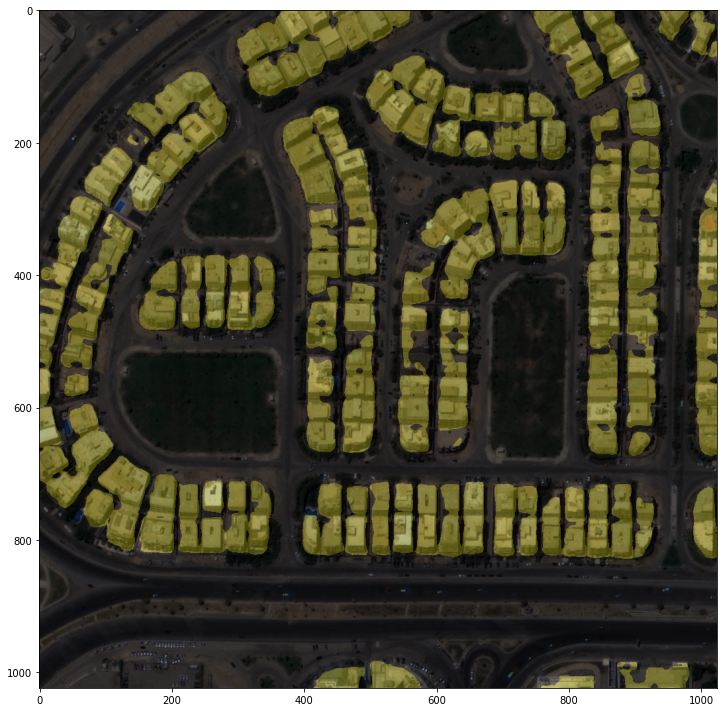

In [ ]:
checkpoint_file = '/content/drive/MyDrive/SIA/semantic_checkpoint/fpn_building/bs/iter_5000.pth'  #학습된 모델

# checkpoint 저장된 model 파일을 이용하여 모델을 생성, 이때 Config는 위에서 update된 config 사용. 
model_ckpt = init_segmentor(cfg, checkpoint_file, device='cuda:0')  #cuda gpu 사용

img = mmcv.imread('/content/drive/MyDrive/SIA/images/up025/BLD00049_PS3_K3A_NIA0276.png')
result = inference_segmentor(model_ckpt, img)
show_result_pyplot(model_ckpt, img, result, palette)

/content/mmsegmentation/mmseg/models/backbones/resnet.py:431: UserWarning: DeprecationWarning: pretrained is a deprecated, please use "init_cfg" instead
  warnings.warn('DeprecationWarning: pretrained is a deprecated, '
/content/mmsegmentation/mmseg/models/losses/cross_entropy_loss.py:236: UserWarning: Default ``avg_non_ignore`` is False, if you would like to ignore the certain label and average loss over non-ignore labels, which is the same with PyTorch official cross_entropy, set ``avg_non_ignore=True``.
  'Default ``avg_non_ignore`` is False, if you would like to '


load checkpoint from local path: /content/drive/MyDrive/SIA/semantic_checkpoint/fpn_building/bs/iter_5000.pth


/content/mmsegmentation/mmseg/models/segmentors/base.py:289: UserWarning: show==False and out_file is not specified, only result image will be returned
  warnings.warn('show==False and out_file is not specified, only '


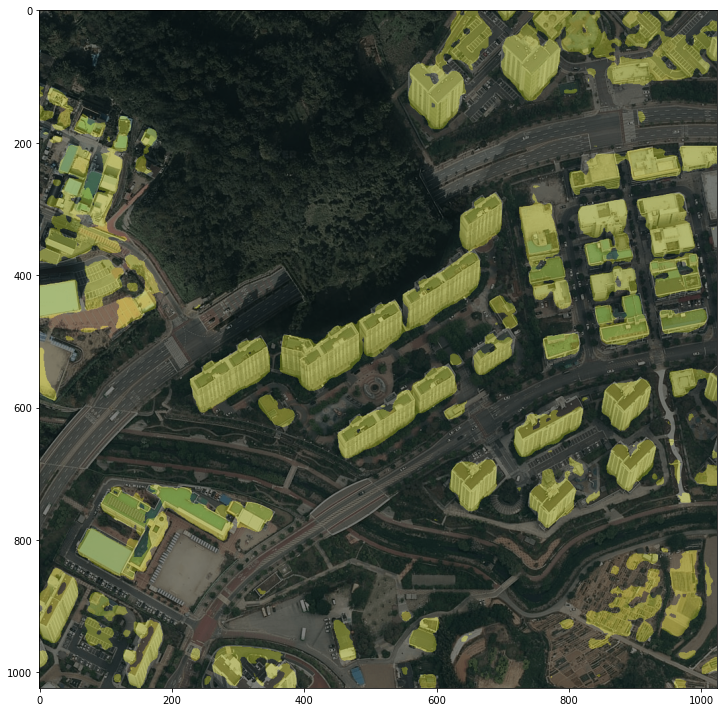

In [ ]:
checkpoint_file = '/content/drive/MyDrive/SIA/semantic_checkpoint/fpn_building/bs/iter_5000.pth'  #학습된 모델

# checkpoint 저장된 model 파일을 이용하여 모델을 생성, 이때 Config는 위에서 update된 config 사용. 
model_ckpt = init_segmentor(cfg, checkpoint_file, device='cuda:0')  #cuda gpu 사용

img = mmcv.imread('/content/drive/MyDrive/SIA/naver_map_images/0000.png')
result = inference_segmentor(model_ckpt, img)
show_result_pyplot(model_ckpt, img, result, palette)

/content/mmsegmentation/mmseg/models/backbones/resnet.py:431: UserWarning: DeprecationWarning: pretrained is a deprecated, please use "init_cfg" instead
  warnings.warn('DeprecationWarning: pretrained is a deprecated, '
/content/mmsegmentation/mmseg/models/losses/cross_entropy_loss.py:236: UserWarning: Default ``avg_non_ignore`` is False, if you would like to ignore the certain label and average loss over non-ignore labels, which is the same with PyTorch official cross_entropy, set ``avg_non_ignore=True``.
  'Default ``avg_non_ignore`` is False, if you would like to '


load checkpoint from local path: /content/drive/MyDrive/SIA/semantic_checkpoint/fpn_building/bs/iter_5000.pth


/content/mmsegmentation/mmseg/models/segmentors/base.py:289: UserWarning: show==False and out_file is not specified, only result image will be returned
  warnings.warn('show==False and out_file is not specified, only '


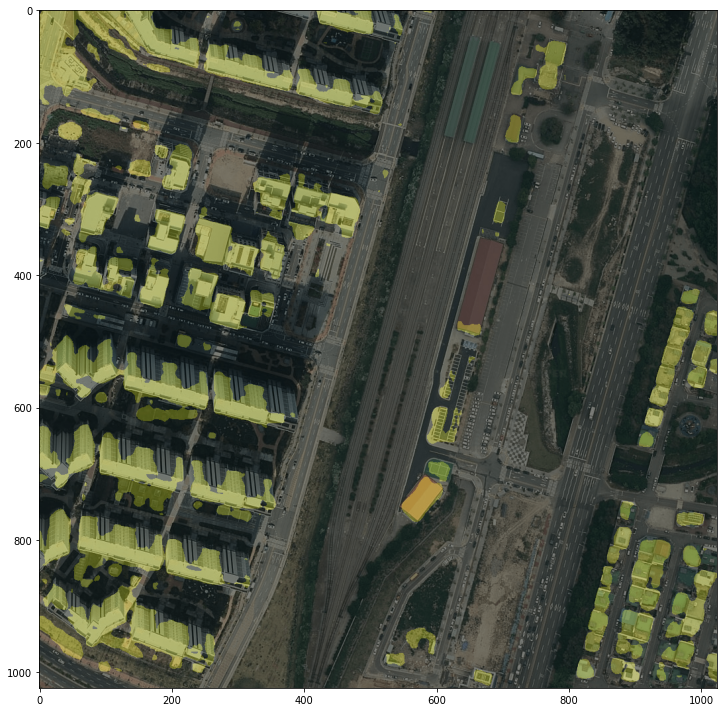

In [ ]:
checkpoint_file = '/content/drive/MyDrive/SIA/semantic_checkpoint/fpn_building/bs/iter_5000.pth'  #학습된 모델

# checkpoint 저장된 model 파일을 이용하여 모델을 생성, 이때 Config는 위에서 update된 config 사용. 
model_ckpt = init_segmentor(cfg, checkpoint_file, device='cuda:0')  #cuda gpu 사용

img = mmcv.imread('/content/drive/MyDrive/SIA/naver_map_images/0001.png')
result = inference_segmentor(model_ckpt, img)
show_result_pyplot(model_ckpt, img, result, palette)

/content/mmsegmentation/mmseg/models/backbones/resnet.py:431: UserWarning: DeprecationWarning: pretrained is a deprecated, please use "init_cfg" instead
  warnings.warn('DeprecationWarning: pretrained is a deprecated, '
/content/mmsegmentation/mmseg/models/losses/cross_entropy_loss.py:236: UserWarning: Default ``avg_non_ignore`` is False, if you would like to ignore the certain label and average loss over non-ignore labels, which is the same with PyTorch official cross_entropy, set ``avg_non_ignore=True``.
  'Default ``avg_non_ignore`` is False, if you would like to '


load checkpoint from local path: /content/drive/MyDrive/SIA/semantic_checkpoint/fpn_building/bs/iter_5000.pth


/content/mmsegmentation/mmseg/models/segmentors/base.py:289: UserWarning: show==False and out_file is not specified, only result image will be returned
  warnings.warn('show==False and out_file is not specified, only '


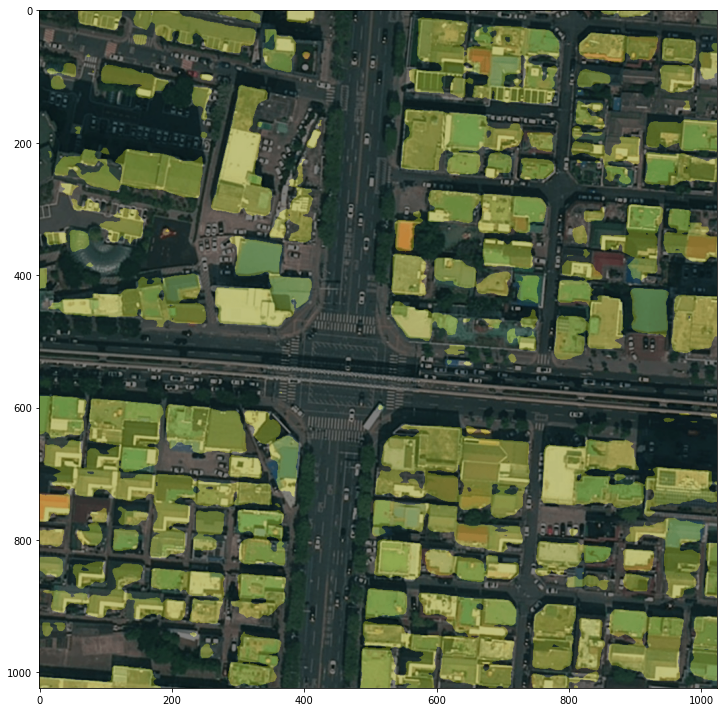

In [ ]:
checkpoint_file = '/content/drive/MyDrive/SIA/semantic_checkpoint/fpn_building/bs/iter_5000.pth'  #학습된 모델

# checkpoint 저장된 model 파일을 이용하여 모델을 생성, 이때 Config는 위에서 update된 config 사용. 
model_ckpt = init_segmentor(cfg, checkpoint_file, device='cuda:0')  #cuda gpu 사용

img = mmcv.imread('/content/drive/MyDrive/SIA/naver_map_images/0002.png')
result = inference_segmentor(model_ckpt, img)
show_result_pyplot(model_ckpt, img, result, palette)